# Mushroom

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## Data Input
Read data with pandas and consider "?" as NaN.

In [2]:
data = pd.read_csv("agaricus-lepiota.data", header=None, na_values = ['?'])
# data.head()

## Data visualization

Create a list to store the names of the features.

In [3]:
featureData = '''cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
bruises?: bruises=t,no=f
odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
gill-attachment: attached=a,descending=d,free=f,notched=n
gill-spacing: close=c,crowded=w,distant=d
gill-size: broad=b,narrow=n
gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
stalk-shape: enlarging=e,tapering=t
stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r, missing=?
stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
veil-type: partial=p,universal=u
veil-color: brown=n,orange=o,white=w,yellow=y
ring-number: none=n,one=o,two=t
ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d'''
featureData = featureData.split('\n')
features = [f[:f.find(': ')] for f in featureData]

Show the data distribution.<br>There are 22 charts to show the distributions of 22 features.

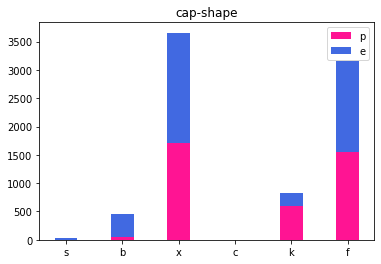

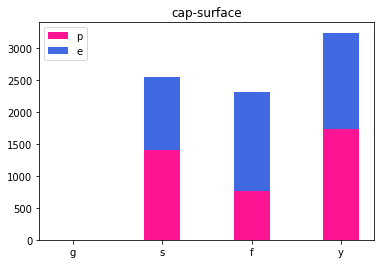

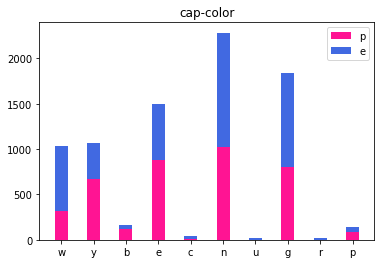

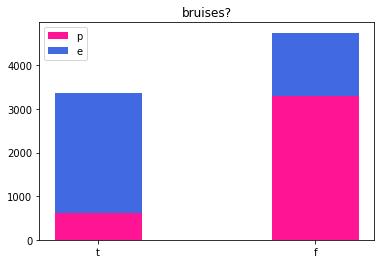

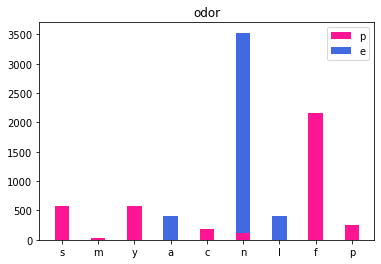

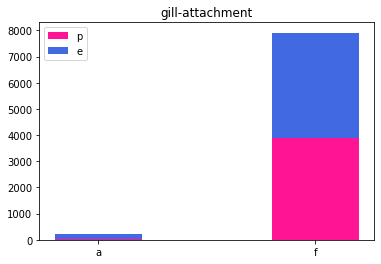

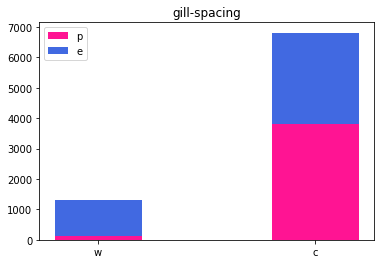

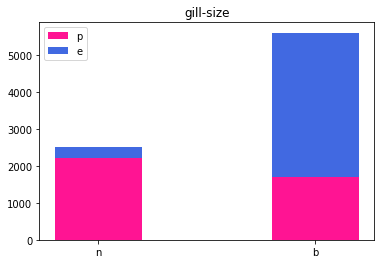

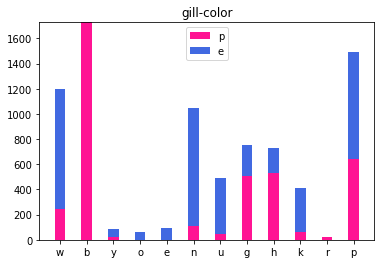

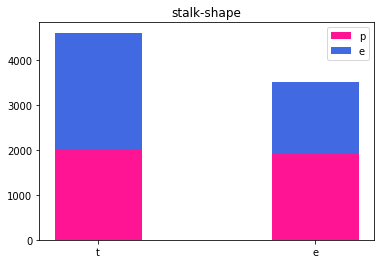

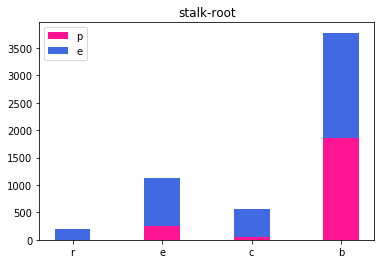

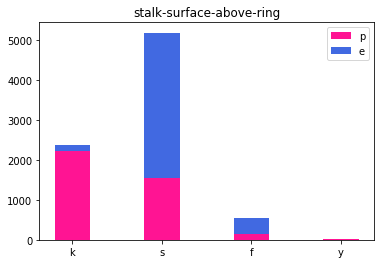

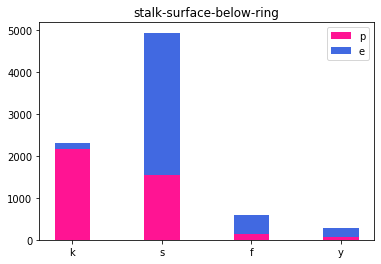

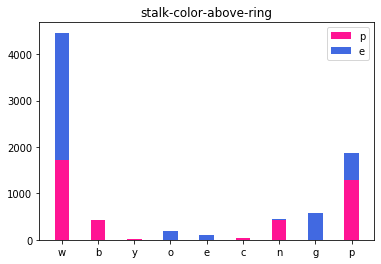

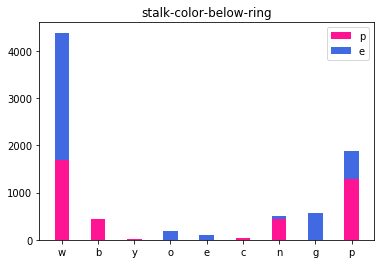

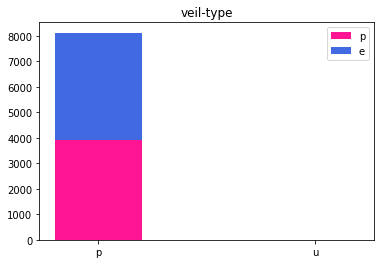

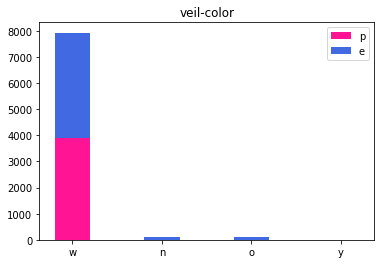

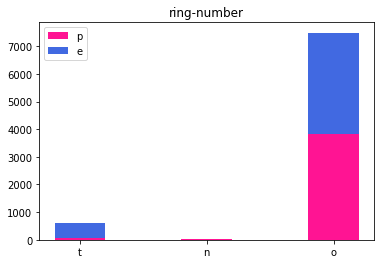

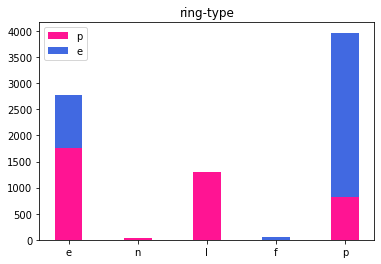

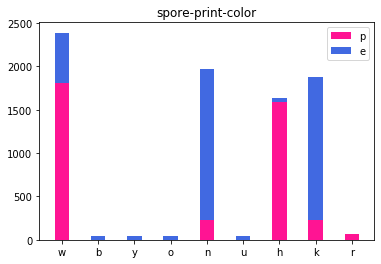

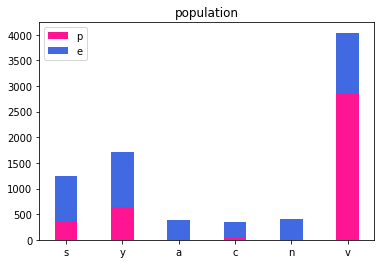

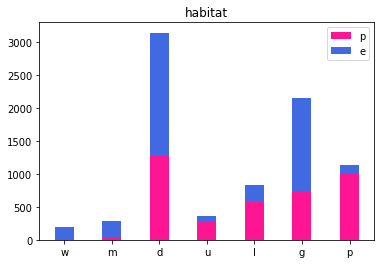

In [4]:
for i in range(1,23):
    d_p = dict(data[data[0]=='p'][i].value_counts())
    d_e = dict(data[data[0]=='e'][i].value_counts())
    keys = list(set(list(d_p)+list(d_e)))
    if i == 16:
        keys.append('u')
    val_p = np.array([d_p.get(key, 0) for key in keys])
    val_e = np.array([d_e.get(key, 0) for key in keys])
    
    plt.bar(keys,val_p,color='deeppink',label='p',width = 0.4)
    plt.bar(keys,val_e,color='royalblue',label='e',bottom=val_p,width = 0.4)
    plt.legend(['p','e'])
    plt.title(features[i-1])
    plt.show()

## Data Preprocessing
Drop features with any missing value.(stalk-root)

In [5]:
new_df = data.dropna(axis=1,how='any')

Transform data format with labelencoder.

In [6]:
le = LabelEncoder()
new_df = new_df.apply(le.fit_transform)

Divide the data into X(features) and y(labels).

In [7]:
X = new_df.iloc[:,1:].to_numpy()
y = new_df.iloc[:,0].to_numpy()

## Model Construction

In [8]:
cnb = sklearn.naive_bayes.CategoricalNB(alpha=1e-9)
cnb_laplace = sklearn.naive_bayes.CategoricalNB(alpha=1)

## Train-Test-Split

### Holdout validation

#### Split

In [9]:
X_train_Holdout, X_test_Holdout, y_train_Holdout, y_test_Holdout = train_test_split(X, y, test_size=0.3)

#### Fitting

In [10]:
y_pred_Holdout_Laplace = cnb_laplace.fit(X_train_Holdout, y_train_Holdout).predict(X_test_Holdout)
y_pred_Holdout = cnb.fit(X_train_Holdout, y_train_Holdout).predict(X_test_Holdout)

### K-fold cross-validation

#### Splitting, Fitting and Calculating the metrics

In [11]:
kf = KFold(n_splits=3, shuffle = True)

cm_KfoldSum = np.zeros([2,2])
cm_KfoldSum_laplace = np.zeros([2,2])
acc_KfoldSum = 0
acc_KfoldSum_laplace = 0
pc_KfoldSum = np.zeros([2])
pc_KfoldSum_laplace = np.zeros([2])
recall_KfoldSum = np.zeros([2])
recall_KfoldSum_laplace = np.zeros([2])

for train_index, test_index in kf.split(X):
    X_train_Kfold, X_test_Kfold = X[train_index], X[test_index]
    y_train_Kfold, y_test_Kfold = y[train_index], y[test_index]
    
    cnb = sklearn.naive_bayes.CategoricalNB(alpha=1e-9)
    cnb_laplace = sklearn.naive_bayes.CategoricalNB(alpha=1)
 
    cnb.fit(X_train_Kfold, y_train_Kfold)
    cnb_laplace.fit(X_train_Kfold, y_train_Kfold)

    y_pred_Kfold = cnb.predict(X_test_Kfold)
    y_pred_Kfold_laplace = cnb_laplace.predict(X_test_Kfold)

    cm = sklearn.metrics.confusion_matrix(y_test_Kfold, y_pred_Kfold).transpose()
    cm_KfoldSum += np.array(cm)
    cm = sklearn.metrics.confusion_matrix(y_test_Kfold, y_pred_Kfold_laplace).transpose()
    cm_KfoldSum_laplace += np.array(cm)

    acc_KfoldSum += sklearn.metrics.accuracy_score(y_test_Kfold, y_pred_Kfold)
    acc_KfoldSum_laplace += sklearn.metrics.accuracy_score(y_test_Kfold, y_pred_Kfold_laplace)
    
    precision_temp, recall_temp, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test_Kfold, y_pred_Kfold)
    pc_KfoldSum += np.array(precision_temp)
    recall_KfoldSum += np.array(recall_temp)
    precision_temp, recall_temp, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test_Kfold, y_pred_Kfold_laplace)
    pc_KfoldSum_laplace += np.array(precision_temp)
    recall_KfoldSum_laplace += np.array(recall_temp)
    
cm_Kfold = cm_KfoldSum/3
acc_Kfold = acc_KfoldSum/3
pc_Kfold = pc_KfoldSum/3
recall_Kfold = recall_KfoldSum/3

cm_Kfold_laplace = cm_KfoldSum_laplace/3
acc_Kfold_laplace = acc_KfoldSum_laplace/3
pc_Kfold_laplace = pc_KfoldSum_laplace/3
recall_Kfold_laplace = recall_KfoldSum_laplace/3

## Results 

### Show the confusion matices

In [12]:
rowInds = list(map(lambda x: 'Predicted '+x, ['edible','poisonous']))
colNames = list(map(lambda x: 'Actual '+x, ['edible','poisonous']))

cmHoldout = sklearn.metrics.confusion_matrix(y_test_Holdout, y_pred_Holdout).transpose()
print('Confusion matrix of Holdout validation without Laplace smoothing')
display(pd.DataFrame(cmHoldout, index=rowInds, columns=colNames))

cmHoldout_Laplace = sklearn.metrics.confusion_matrix(y_test_Holdout, y_pred_Holdout_Laplace).transpose()
print('Confusion matrix of Holdout validation with Laplace smoothing')
display(pd.DataFrame(cmHoldout_Laplace, index=rowInds, columns=colNames))

print('Confusion matrix of K-fold cross-validation without Laplace smoothing')
display(pd.DataFrame(cm_Kfold, index=rowInds, columns=colNames))

print('Confusion matrix of K-fold cross-validation with Laplace smoothing')
display(pd.DataFrame(cm_Kfold_laplace, index=rowInds, columns=colNames))

Confusion matrix of Holdout validation without Laplace smoothing


Actual edible  Actual poisonous
Predicted edible              1304                 0
Predicted poisonous              7              1127

Confusion matrix of Holdout validation with Laplace smoothing


Actual edible  Actual poisonous
Predicted edible              1304                87
Predicted poisonous              7              1040

Confusion matrix of K-fold cross-validation without Laplace smoothing


Actual edible  Actual poisonous
Predicted edible       1394.666667          1.000000
Predicted poisonous       8.000000       1304.333333

Confusion matrix of K-fold cross-validation with Laplace smoothing


Actual edible  Actual poisonous
Predicted edible       1394.333333        102.333333
Predicted poisonous       8.333333       1203.000000

### Show the accuracy

In [13]:
acc_holdout = sklearn.metrics.accuracy_score(y_test_Holdout, y_pred_Holdout)
acc_holdout_laplace = sklearn.metrics.accuracy_score(y_test_Holdout, y_pred_Holdout_Laplace)
print('Accuracy')
display(pd.DataFrame(np.array([[acc_holdout,acc_Kfold],[acc_holdout_laplace,acc_Kfold_laplace,]]), index=['w/o laplace', 'w/ laplace'], columns=['Holdout validation','K-fold cross-validation']))

Accuracy


Holdout validation  K-fold cross-validation
w/o laplace            0.997129                 0.996677
w/ laplace             0.961444                 0.959133

### Show the sensitivities(recalls) and precisions

In [14]:
# Calculate the recall and the precision of the holdout
pc_Holdout, recall_Holdout, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test_Holdout, y_pred_Holdout)
pc_Holdout_laplace, recall_Holdout_laplace, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test_Holdout, y_pred_Holdout_Laplace)

print('Sensitivity(Recall)')
display(pd.DataFrame(np.array([recall_Holdout,recall_Holdout_laplace,recall_Kfold,recall_Kfold_laplace]), index=['Holdout without Laplace','Holdout with Laplace','K-fold  without Laplace', 'K-fold  with Laplace'], columns=['edible','poisonous']))

print('Precision')
display(pd.DataFrame(np.array([pc_Holdout,pc_Holdout_laplace,pc_Kfold,pc_Kfold_laplace]), index=['Holdout without Laplace','Holdout with Laplace','K-fold  without Laplace', 'K-fold  with Laplace'], columns=['edible','poisonous']))

Sensitivity(Recall)


edible  poisonous
Holdout without Laplace  0.994661   1.000000
Holdout with Laplace     0.994661   0.922804
K-fold  without Laplace  0.994284   0.999241
K-fold  with Laplace     0.994044   0.921678

Precision


edible  poisonous
Holdout without Laplace  1.000000   0.993827
Holdout with Laplace     0.937455   0.993314
K-fold  without Laplace  0.999277   0.993917
K-fold  with Laplace     0.931605   0.993128

## Comparison & Conclusion
From the results, the performances of experiments with the Laplace smoothing will be lower.

## Questions 
### Show 𝑃(𝑋𝑠𝑡𝑎𝑙𝑘−𝑐𝑜𝑙𝑜𝑟−𝑏𝑒𝑙𝑜𝑤−𝑟𝑖𝑛𝑔|𝑌=𝑒) with and without Laplace smoothing by bar charts
𝜏 = 9, k=10
- Without Laplace smoothing
<br> $𝑃(𝑋_𝑖|𝑌)=\frac{𝑁(𝑋_𝑖|𝑌)}{𝑁(𝑌)}$
- Laplace smoothing
<br> $𝑃(𝑋_𝑖|𝑌)=\frac{𝑁(𝑋_𝑖|𝑌)+𝑘}{𝑁(𝑌)+𝑘𝜏}$

#### Setting parameters

In [15]:
N_Y = len(data[data[0]=='e'])
X_i = data[15].unique()
tau = len(X_i)
k = 10
N_Xi_Y_dict = dict(data[data[0]=='e'][15].value_counts())
tempKeys = list(N_Xi_Y_dict.keys())
for x in X_i:
    if x not in tempKeys:
        N_Xi_Y_dict[x] = 0

#### Show the bar charts
You can find that features b, y, c that didn't appear originally have a non-zero likelihood probability after laplace smoothing.

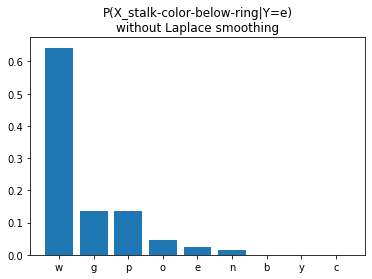

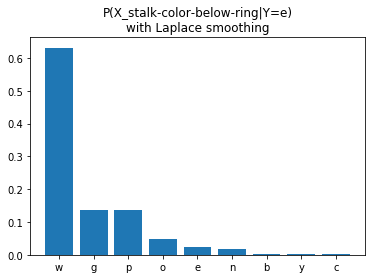

In [16]:
keys = list(N_Xi_Y_dict.keys())

vals = list(map(lambda x: x/N_Y, list(N_Xi_Y_dict.values())))

plt.bar(keys,vals)
plt.title('P(X_stalk-color-below-ring|Y=e)\nwithout Laplace smoothing')
plt.show()

vals = list(map(lambda x: (x+k)/(N_Y+k*tau), list(N_Xi_Y_dict.values())))

plt.bar(keys,vals)
plt.title('P(X_stalk-color-below-ring|Y=e)\nwith Laplace smoothing')
plt.show()